In [15]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [17]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [18]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [19]:
tf.keras.backend.clear_session()

In [20]:
subject = 'Alagoas - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [21]:
data = pd.read_csv('2003_mo_model_input_AL.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - Consumo de Cimento (t),Alagoas - IDH Longevidade,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.635160,1.594356e+06,30.109,0.728082,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.635571,1.598004e+06,27.684,0.728532,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.635982,1.601652e+06,26.534,0.728982,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.636393,1.605299e+06,25.109,0.729432,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.636804,1.608947e+06,25.171,0.729882,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


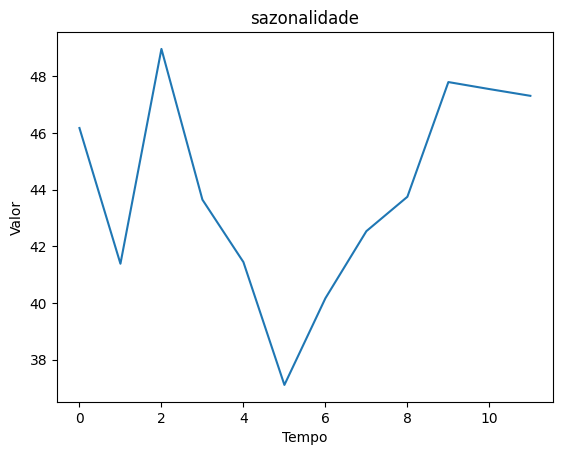

,sazonalidade
sazonalidade,
0,46.174340
1,41.382404
2,48.967201
3,43.643633
4,41.440538
5,37.102875
6,40.163254
7,42.532381
8,43.746386


In [22]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [23]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Alagoas - Consumo de Cimento (t)
0,2003-1,0.635160,1.594356e+06,0.728082,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,46.174340,30.109
1,2003-2,0.635571,1.598004e+06,0.728532,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,41.382404,27.684
2,2003-3,0.635982,1.601652e+06,0.728982,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,48.967201,26.534
3,2003-4,0.636393,1.605299e+06,0.729432,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,43.643633,25.109
4,2003-5,0.636804,1.608947e+06,0.729882,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,41.440538,25.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.440538,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.102875,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.163254,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.532381,NaN


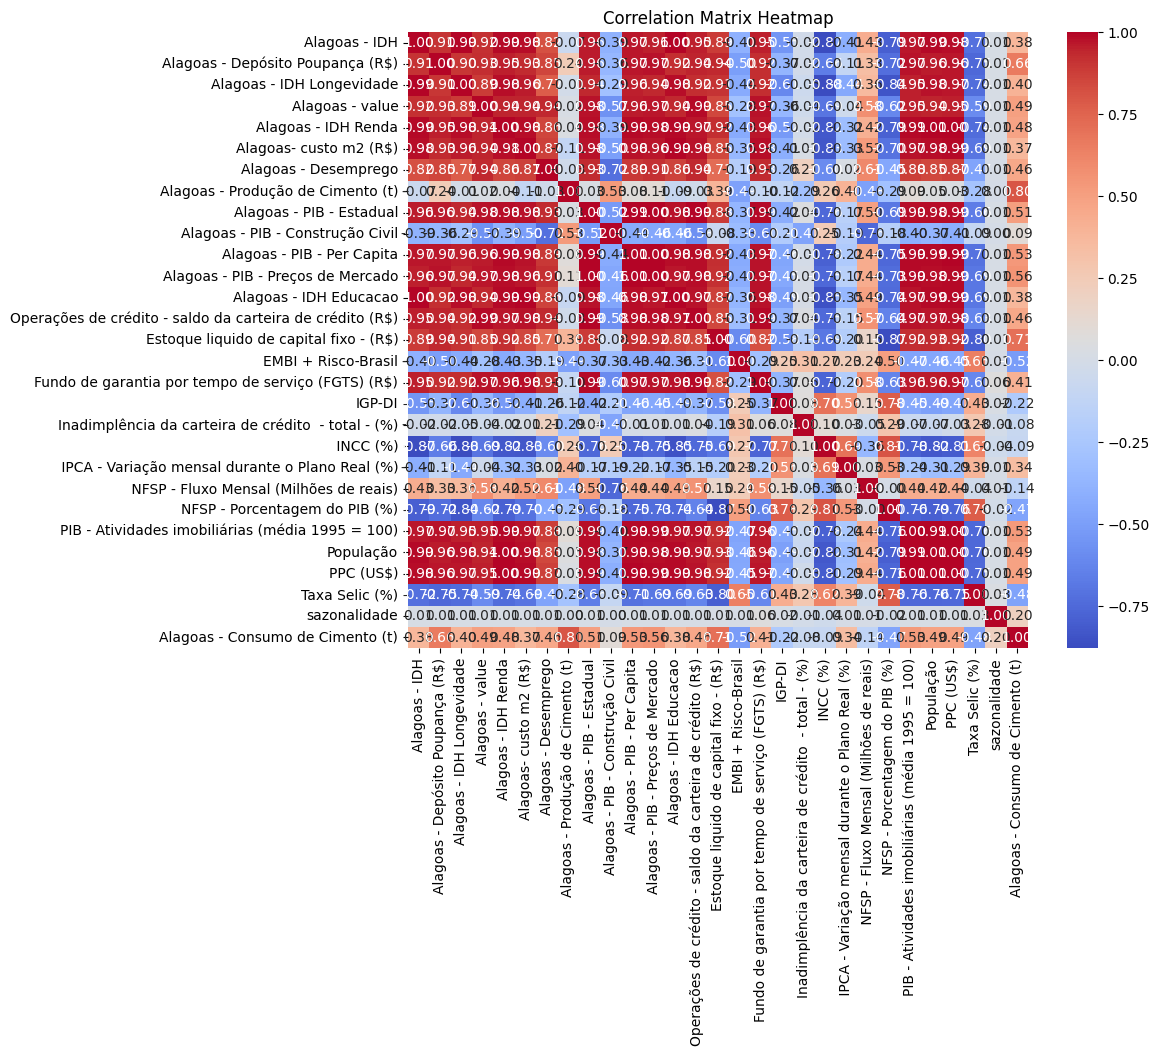

In [24]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [25]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [26]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.106195,-1.530382,-2.341266,-1.400856,-2.020319,-1.669609,-0.877266,-0.885888,-1.644358,-1.297696,-1.913990,-1.857572,-1.869642,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.629158
1,-2.072296,-1.525621,-2.298242,-1.374741,-1.992420,-1.646753,-0.879298,-0.900149,-1.627544,-1.242142,-1.888746,-1.832102,-1.845435,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-0.747411
2,-2.038397,-1.520861,-2.255217,-1.355481,-1.964522,-1.625048,-0.881330,-0.904358,-1.610731,-1.186588,-1.863502,-1.806633,-1.821228,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,1.431457
3,-2.004498,-1.516101,-2.212193,-1.337169,-1.936624,-1.604976,-0.883362,-0.917668,-1.593917,-1.131034,-1.838257,-1.781163,-1.797020,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.097832
4,-1.970599,-1.511340,-2.169169,-1.319844,-1.908725,-1.585341,-0.885394,-0.910766,-1.577104,-1.075480,-1.813013,-1.755694,-1.772813,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.730711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.358381,1.085830,1.149323,0.990315,1.237578,1.709180,1.043483,-1.575976,1.179374,-1.254203,1.153065,1.054229,1.447389,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,-0.417060
188,1.351367,1.093373,1.133233,1.000562,1.237778,1.731138,1.037328,-1.527002,1.172432,-1.239868,1.147901,1.048854,1.445125,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,-0.068315
189,1.344353,1.100916,1.117143,1.011398,1.237978,1.755600,1.031173,-1.472984,1.165489,-1.225534,1.142737,1.043480,1.442862,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.095283
190,1.337339,1.108459,1.101053,1.028853,1.238178,1.781919,1.025017,-1.478716,1.158547,-1.211200,1.137574,1.038106,1.440598,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,1.024162


In [27]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      24.166
1      21.774
2      28.228
3      25.525
4      26.207
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Alagoas - Consumo de Cimento (t), Length: 249, dtype: float64

In [28]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.106195,-1.530382,-2.341266,-1.400856,-2.020319,-1.669609,-0.877266,-0.885888,-1.644358,-1.297696,-1.913990,-1.857572,-1.869642,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.629158
1,-2.072296,-1.525621,-2.298242,-1.374741,-1.992420,-1.646753,-0.879298,-0.900149,-1.627544,-1.242142,-1.888746,-1.832102,-1.845435,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-0.747411
2,-2.038397,-1.520861,-2.255217,-1.355481,-1.964522,-1.625048,-0.881330,-0.904358,-1.610731,-1.186588,-1.863502,-1.806633,-1.821228,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,1.431457
3,-2.004498,-1.516101,-2.212193,-1.337169,-1.936624,-1.604976,-0.883362,-0.917668,-1.593917,-1.131034,-1.838257,-1.781163,-1.797020,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.097832
4,-1.970599,-1.511340,-2.169169,-1.319844,-1.908725,-1.585341,-0.885394,-0.910766,-1.577104,-1.075480,-1.813013,-1.755694,-1.772813,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.730711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.429306,0.722140,1.455915,1.348585,1.295486,1.113859,1.320458,-0.588269,1.217771,-1.179058,1.109023,1.141942,1.389696,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-0.747411
158,1.428089,0.730943,1.450028,1.330705,1.293308,1.136891,1.307307,-0.687207,1.221600,-1.195069,1.116989,1.144540,1.392571,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,1.431457
159,1.426872,0.739747,1.444141,1.311609,1.291129,1.160109,1.294156,-0.785508,1.225429,-1.211080,1.124956,1.147138,1.395445,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-0.097832
160,1.425655,0.748550,1.438254,1.291203,1.288951,1.182400,1.281004,-0.883126,1.229259,-1.227092,1.132922,1.149736,1.398320,1.306664,0.785801,1.017171,1.240363,-1.068274,1.048868,-1.103668,-0.614500,1.147619,-0.640320,0.956331,1.065381,1.083626,0.392942,-0.730711


In [29]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      24.166
1      21.774
2      28.228
3      25.525
4      26.207
        ...  
157    32.321
158    41.937
159    31.982
160    28.499
161    22.626
Name: Alagoas - Consumo de Cimento (t), Length: 162, dtype: float64

In [30]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [31]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 28)

In [32]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size : split_index + 1]
test_input

,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.408114,1.042755,0.391352,0.871197,0.694268,0.434118,1.001453,1.498208,0.788737,-0.193817,0.746412,0.852250,0.452419,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,-1.097634
127,0.417817,1.046884,0.391779,0.912736,0.692834,0.451482,1.019577,1.468126,0.809677,-0.237777,0.767524,0.871358,0.468215,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,-0.417060
128,0.427521,1.051012,0.392207,0.960653,0.691399,0.470371,1.037701,1.431617,0.830616,-0.281737,0.788636,0.890466,0.484011,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,-0.068315
129,0.437224,1.055141,0.392634,1.006010,0.689965,0.488879,1.055825,1.391868,0.851555,-0.325697,0.809748,0.909574,0.499808,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.095283
130,0.446928,1.059269,0.393062,1.054871,0.688530,0.507871,1.073949,1.349013,0.872494,-0.369657,0.830860,0.928682,0.515604,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,1.024162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.358381,1.085830,1.149323,0.990315,1.237578,1.709180,1.043483,-1.575976,1.179374,-1.254203,1.153065,1.054229,1.447389,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,-0.417060
188,1.351367,1.093373,1.133233,1.000562,1.237778,1.731138,1.037328,-1.527002,1.172432,-1.239868,1.147901,1.048854,1.445125,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,-0.068315
189,1.344353,1.100916,1.117143,1.011398,1.237978,1.755600,1.031173,-1.472984,1.165489,-1.225534,1.142737,1.043480,1.442862,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.095283
190,1.337339,1.108459,1.101053,1.028853,1.238178,1.781919,1.025017,-1.478716,1.158547,-1.211200,1.137574,1.038106,1.440598,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,1.024162


In [33]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 28)

In [34]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [35]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(36, activation='tanh'),
        tf.keras.layers.Dense(18, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')    
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
#                         validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [36]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(20)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [37]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2154659259, 3488958692, 2305782482, 30910222, 3805759540, 1636698084, 1303880359, 4293786355, 2036828696, 3909615823, 1462097584, 157481049, 621444076, 2110602585, 2227945920, 4098909283, 1355789210, 2060284136, 2129150392, 1103943675]


Step: 0 ___________________________________________


2023-10-21 19:22:30.847373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 19:22:30.847543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 19:22:30.847680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

KeyboardInterrupt: 

In [38]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=3564501792)

Epoch 1/10000
4/4 [==============================] - 2s 118ms/step - loss: 2698.5200 - val_loss: 2697.7244
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 2639.4307 - val_loss: 2633.8242
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 2578.4744 - val_loss: 2571.9385
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 2525.6082 - val_loss: 2518.5557
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 2473.0317 - val_loss: 2474.9900
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 2432.7717 - val_loss: 2438.4324
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 2393.2803 - val_loss: 2407.4990
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 2363.8870 - val_loss: 2381.9319
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 2337.2034 - val_loss: 2360.4561
Epoch 10/10000
4/4 [=============================

4/4 [==============================] - 0s 8ms/step - loss: 1792.8049 - val_loss: 1841.5502
Epoch 79/10000
4/4 [==============================] - 0s 8ms/step - loss: 1786.8735 - val_loss: 1835.6517
Epoch 80/10000
4/4 [==============================] - 0s 8ms/step - loss: 1780.9536 - val_loss: 1829.7528
Epoch 81/10000
4/4 [==============================] - 0s 8ms/step - loss: 1774.9896 - val_loss: 1823.9253
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 1769.1851 - val_loss: 1818.1138
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 1763.3070 - val_loss: 1812.3206
Epoch 84/10000
4/4 [==============================] - 0s 13ms/step - loss: 1757.4486 - val_loss: 1806.5962
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 1751.6108 - val_loss: 1800.9155
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 1745.9619 - val_loss: 1795.1770
Epoch 87/10000
4/4 [==============================] - 0s 8m

4/4 [==============================] - 0s 9ms/step - loss: 1392.1752 - val_loss: 1444.9536
Epoch 155/10000
4/4 [==============================] - 0s 10ms/step - loss: 1387.3917 - val_loss: 1440.3185
Epoch 156/10000
4/4 [==============================] - 0s 9ms/step - loss: 1382.7627 - val_loss: 1435.6689
Epoch 157/10000
4/4 [==============================] - 0s 9ms/step - loss: 1378.0890 - val_loss: 1431.0150
Epoch 158/10000
4/4 [==============================] - 0s 8ms/step - loss: 1373.3472 - val_loss: 1426.3885
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 1368.7662 - val_loss: 1421.7566
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 1364.0698 - val_loss: 1417.1748
Epoch 161/10000
4/4 [==============================] - 0s 8ms/step - loss: 1359.4696 - val_loss: 1412.6290
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 1354.8524 - val_loss: 1408.1554
Epoch 163/10000
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 1076.1177 - val_loss: 1132.5308
Epoch 231/10000
4/4 [==============================] - 0s 9ms/step - loss: 1072.4601 - val_loss: 1128.8357
Epoch 232/10000
4/4 [==============================] - 0s 10ms/step - loss: 1068.7310 - val_loss: 1125.1943
Epoch 233/10000
4/4 [==============================] - 0s 9ms/step - loss: 1065.0646 - val_loss: 1121.5654
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 1061.3798 - val_loss: 1117.9557
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 1057.7109 - val_loss: 1114.3394
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 1054.1805 - val_loss: 1110.6851
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 1050.4581 - val_loss: 1107.0939
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 1046.7638 - val_loss: 1103.5486
Epoch 239/10000
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 823.4047 - val_loss: 883.0117
Epoch 308/10000
4/4 [==============================] - 0s 10ms/step - loss: 820.5543 - val_loss: 880.1844
Epoch 309/10000
4/4 [==============================] - 0s 10ms/step - loss: 817.6395 - val_loss: 877.3984
Epoch 310/10000
4/4 [==============================] - 0s 10ms/step - loss: 814.8964 - val_loss: 874.5939
Epoch 311/10000
4/4 [==============================] - 0s 10ms/step - loss: 812.0298 - val_loss: 871.8306
Epoch 312/10000
4/4 [==============================] - 0s 9ms/step - loss: 809.2488 - val_loss: 869.0989
Epoch 313/10000
4/4 [==============================] - 0s 9ms/step - loss: 806.4648 - val_loss: 866.3680
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 803.6504 - val_loss: 863.6389
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 800.9196 - val_loss: 860.8748
Epoch 316/10000
4/4 [==============================] - 0s 11ms/st

Epoch 385/10000
4/4 [==============================] - 0s 9ms/step - loss: 628.5888 - val_loss: 691.2766
Epoch 386/10000
4/4 [==============================] - 0s 10ms/step - loss: 626.4906 - val_loss: 689.1358
Epoch 387/10000
4/4 [==============================] - 0s 11ms/step - loss: 624.3315 - val_loss: 686.9951
Epoch 388/10000
4/4 [==============================] - 0s 11ms/step - loss: 622.1056 - val_loss: 684.8641
Epoch 389/10000
4/4 [==============================] - 0s 10ms/step - loss: 619.9562 - val_loss: 682.7167
Epoch 390/10000
4/4 [==============================] - 0s 10ms/step - loss: 617.8558 - val_loss: 680.5507
Epoch 391/10000
4/4 [==============================] - 0s 10ms/step - loss: 615.6513 - val_loss: 678.4213
Epoch 392/10000
4/4 [==============================] - 0s 10ms/step - loss: 613.4952 - val_loss: 676.3162
Epoch 393/10000
4/4 [==============================] - 0s 9ms/step - loss: 611.3633 - val_loss: 674.2498
Epoch 394/10000
4/4 [===========================

4/4 [==============================] - 0s 10ms/step - loss: 483.8289 - val_loss: 549.0896
Epoch 463/10000
4/4 [==============================] - 0s 9ms/step - loss: 482.2070 - val_loss: 547.5232
Epoch 464/10000
4/4 [==============================] - 0s 9ms/step - loss: 480.5944 - val_loss: 545.9332
Epoch 465/10000
4/4 [==============================] - 0s 9ms/step - loss: 478.9364 - val_loss: 544.3633
Epoch 466/10000
4/4 [==============================] - 0s 10ms/step - loss: 477.3784 - val_loss: 542.7751
Epoch 467/10000
4/4 [==============================] - 0s 10ms/step - loss: 475.7964 - val_loss: 541.1979
Epoch 468/10000
4/4 [==============================] - 0s 10ms/step - loss: 474.2204 - val_loss: 539.6326
Epoch 469/10000
4/4 [==============================] - 0s 10ms/step - loss: 472.6553 - val_loss: 538.0995
Epoch 470/10000
4/4 [==============================] - 0s 10ms/step - loss: 471.0782 - val_loss: 536.5974
Epoch 471/10000
4/4 [==============================] - 0s 10ms/st

Epoch 540/10000
4/4 [==============================] - 0s 10ms/step - loss: 379.2100 - val_loss: 446.8490
Epoch 541/10000
4/4 [==============================] - 0s 10ms/step - loss: 378.1322 - val_loss: 445.7814
Epoch 542/10000
4/4 [==============================] - 0s 10ms/step - loss: 377.0321 - val_loss: 444.7180
Epoch 543/10000
4/4 [==============================] - 0s 10ms/step - loss: 375.9317 - val_loss: 443.6524
Epoch 544/10000
4/4 [==============================] - 0s 9ms/step - loss: 374.8809 - val_loss: 442.5612
Epoch 545/10000
4/4 [==============================] - 0s 9ms/step - loss: 373.7576 - val_loss: 441.4784
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 372.6820 - val_loss: 440.3988
Epoch 547/10000
4/4 [==============================] - 0s 10ms/step - loss: 371.4977 - val_loss: 439.3540
Epoch 548/10000
4/4 [==============================] - 0s 10ms/step - loss: 370.4211 - val_loss: 438.2975
Epoch 549/10000
4/4 [============================

4/4 [==============================] - 0s 10ms/step - loss: 307.9243 - val_loss: 377.5320
Epoch 618/10000
4/4 [==============================] - 0s 10ms/step - loss: 307.1502 - val_loss: 376.8132
Epoch 619/10000
4/4 [==============================] - 0s 9ms/step - loss: 306.4027 - val_loss: 376.0989
Epoch 620/10000
4/4 [==============================] - 0s 9ms/step - loss: 305.6837 - val_loss: 375.3708
Epoch 621/10000
4/4 [==============================] - 0s 9ms/step - loss: 304.9693 - val_loss: 374.6464
Epoch 622/10000
4/4 [==============================] - 0s 9ms/step - loss: 304.1732 - val_loss: 373.9515
Epoch 623/10000
4/4 [==============================] - 0s 10ms/step - loss: 303.4549 - val_loss: 373.2320
Epoch 624/10000
4/4 [==============================] - 0s 10ms/step - loss: 302.7576 - val_loss: 372.5111
Epoch 625/10000
4/4 [==============================] - 0s 9ms/step - loss: 301.9699 - val_loss: 371.8165
Epoch 626/10000
4/4 [==============================] - 0s 10ms/step

4/4 [==============================] - 0s 10ms/step - loss: 260.9005 - val_loss: 332.2484
Epoch 695/10000
4/4 [==============================] - 0s 10ms/step - loss: 260.4059 - val_loss: 331.7929
Epoch 696/10000
4/4 [==============================] - 0s 10ms/step - loss: 259.9505 - val_loss: 331.3409
Epoch 697/10000
4/4 [==============================] - 0s 10ms/step - loss: 259.4677 - val_loss: 330.8929
Epoch 698/10000
4/4 [==============================] - 0s 9ms/step - loss: 259.0113 - val_loss: 330.4344
Epoch 699/10000
4/4 [==============================] - 0s 9ms/step - loss: 258.5287 - val_loss: 329.9708
Epoch 700/10000
4/4 [==============================] - 0s 10ms/step - loss: 258.1263 - val_loss: 329.5089
Epoch 701/10000
4/4 [==============================] - 0s 11ms/step - loss: 257.6101 - val_loss: 329.0868
Epoch 702/10000
4/4 [==============================] - 0s 11ms/step - loss: 257.1555 - val_loss: 328.6813
Epoch 703/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 9ms/step - loss: 233.2164 - val_loss: 305.9661
Epoch 772/10000
4/4 [==============================] - 0s 10ms/step - loss: 232.9791 - val_loss: 305.7065
Epoch 773/10000
4/4 [==============================] - 0s 10ms/step - loss: 232.6776 - val_loss: 305.4691
Epoch 774/10000
4/4 [==============================] - 0s 10ms/step - loss: 232.4551 - val_loss: 305.2089
Epoch 775/10000
4/4 [==============================] - 0s 10ms/step - loss: 232.1683 - val_loss: 304.9528
Epoch 776/10000
4/4 [==============================] - 0s 10ms/step - loss: 231.9208 - val_loss: 304.6986
Epoch 777/10000
4/4 [==============================] - 0s 10ms/step - loss: 231.6342 - val_loss: 304.4650
Epoch 778/10000
4/4 [==============================] - 0s 9ms/step - loss: 231.3967 - val_loss: 304.2326
Epoch 779/10000
4/4 [==============================] - 0s 9ms/step - loss: 231.1150 - val_loss: 304.0046
Epoch 780/10000
4/4 [==============================] - 0s 9ms/ste

4/4 [==============================] - 0s 9ms/step - loss: 217.6079 - val_loss: 291.4462
Epoch 849/10000
4/4 [==============================] - 0s 9ms/step - loss: 217.4737 - val_loss: 291.3196
Epoch 850/10000
4/4 [==============================] - 0s 9ms/step - loss: 217.3432 - val_loss: 291.1854
Epoch 851/10000
4/4 [==============================] - 0s 10ms/step - loss: 217.1895 - val_loss: 291.0606
Epoch 852/10000
4/4 [==============================] - 0s 10ms/step - loss: 217.0690 - val_loss: 290.9232
Epoch 853/10000
4/4 [==============================] - 0s 10ms/step - loss: 216.9192 - val_loss: 290.7870
Epoch 854/10000
4/4 [==============================] - 0s 10ms/step - loss: 216.7700 - val_loss: 290.6576
Epoch 855/10000
4/4 [==============================] - 0s 10ms/step - loss: 216.6205 - val_loss: 290.5328
Epoch 856/10000
4/4 [==============================] - 0s 10ms/step - loss: 216.5028 - val_loss: 290.3951
Epoch 857/10000
4/4 [==============================] - 0s 9ms/ste

4/4 [==============================] - 0s 10ms/step - loss: 209.9057 - val_loss: 284.5335
Epoch 926/10000
4/4 [==============================] - 0s 11ms/step - loss: 209.8566 - val_loss: 284.4780
Epoch 927/10000
4/4 [==============================] - 0s 11ms/step - loss: 209.7939 - val_loss: 284.4279
Epoch 928/10000
4/4 [==============================] - 0s 11ms/step - loss: 209.7337 - val_loss: 284.3810
Epoch 929/10000
4/4 [==============================] - 0s 10ms/step - loss: 209.6723 - val_loss: 284.3381
Epoch 930/10000
4/4 [==============================] - 0s 10ms/step - loss: 209.6232 - val_loss: 284.2909
Epoch 931/10000
4/4 [==============================] - 0s 10ms/step - loss: 209.5769 - val_loss: 284.2400
Epoch 932/10000
4/4 [==============================] - 0s 9ms/step - loss: 209.5065 - val_loss: 284.1927
Epoch 933/10000
4/4 [==============================] - 0s 9ms/step - loss: 209.4634 - val_loss: 284.1412
Epoch 934/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 9ms/step - loss: 206.3728 - val_loss: 281.5775
Epoch 1003/10000
4/4 [==============================] - 0s 9ms/step - loss: 206.3568 - val_loss: 281.5587
Epoch 1004/10000
4/4 [==============================] - 0s 9ms/step - loss: 206.3268 - val_loss: 281.5382
Epoch 1005/10000
4/4 [==============================] - 0s 10ms/step - loss: 206.3102 - val_loss: 281.5118
Epoch 1006/10000
4/4 [==============================] - 0s 10ms/step - loss: 206.2645 - val_loss: 281.4926
Epoch 1007/10000
4/4 [==============================] - 0s 10ms/step - loss: 206.2424 - val_loss: 281.4702
Epoch 1008/10000
4/4 [==============================] - 0s 10ms/step - loss: 206.2231 - val_loss: 281.4469
Epoch 1009/10000
4/4 [==============================] - 0s 9ms/step - loss: 206.1817 - val_loss: 281.4257
Epoch 1010/10000
4/4 [==============================] - 0s 10ms/step - loss: 206.1691 - val_loss: 281.4010
Epoch 1011/10000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 10ms/step - loss: 204.9663 - val_loss: 280.5679
Epoch 1080/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.9512 - val_loss: 280.5631
Epoch 1081/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.9459 - val_loss: 280.5577
Epoch 1082/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.9335 - val_loss: 280.5527
Epoch 1083/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.9293 - val_loss: 280.5457
Epoch 1084/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.9125 - val_loss: 280.5396
Epoch 1085/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.9054 - val_loss: 280.5336
Epoch 1086/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.8907 - val_loss: 280.5299
Epoch 1087/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.8940 - val_loss: 280.5254
Epoch 1088/10000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 11ms/step - loss: 204.6108 - val_loss: 280.4154
Epoch 1157/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.6085 - val_loss: 280.4149
Epoch 1158/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.6055 - val_loss: 280.4145
Epoch 1159/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.6036 - val_loss: 280.4143
Epoch 1160/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.6002 - val_loss: 280.4142
Epoch 1161/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5998 - val_loss: 280.4139
Epoch 1162/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5969 - val_loss: 280.4138
Epoch 1163/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5927 - val_loss: 280.4134
Epoch 1164/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.6110 - val_loss: 280.4129
Epoch 1165/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 9ms/step - loss: 204.5240 - val_loss: 280.4221
Epoch 1234/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5243 - val_loss: 280.4218
Epoch 1235/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.5251 - val_loss: 280.4220
Epoch 1236/10000
4/4 [==============================] - 0s 11ms/step - loss: 204.5273 - val_loss: 280.4220
Epoch 1237/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.5240 - val_loss: 280.4215
Epoch 1238/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5323 - val_loss: 280.4208
Epoch 1239/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5271 - val_loss: 280.4211
Epoch 1240/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5245 - val_loss: 280.4217
Epoch 1241/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.5264 - val_loss: 280.4231
Epoch 1242/10000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 8ms/step - loss: 204.5062 - val_loss: 280.4373
Epoch 1311/10000
4/4 [==============================] - 0s 8ms/step - loss: 204.5201 - val_loss: 280.4387
Epoch 1312/10000
4/4 [==============================] - 0s 8ms/step - loss: 204.5064 - val_loss: 280.4377
Epoch 1313/10000
4/4 [==============================] - 0s 8ms/step - loss: 204.5063 - val_loss: 280.4379
Epoch 1314/10000
4/4 [==============================] - 0s 8ms/step - loss: 204.5089 - val_loss: 280.4375
Epoch 1315/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5053 - val_loss: 280.4386
Epoch 1316/10000
4/4 [==============================] - 0s 8ms/step - loss: 204.5055 - val_loss: 280.4387
Epoch 1317/10000
4/4 [==============================] - 0s 8ms/step - loss: 204.5035 - val_loss: 280.4381
Epoch 1318/10000
4/4 [==============================] - 0s 8ms/step - loss: 204.5049 - val_loss: 280.4373
Epoch 1319/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 9ms/step - loss: 410.9810 - val_loss: 280.4919
Epoch 1388/10000
4/4 [==============================] - 0s 9ms/step - loss: 204.5525 - val_loss: 280.5033
Epoch 1389/10000
4/4 [==============================] - 0s 8ms/step - loss: 205.1653 - val_loss: 280.5297
Epoch 1390/10000
4/4 [==============================] - 0s 9ms/step - loss: 205.0296 - val_loss: 280.4955
Epoch 1391/10000
4/4 [==============================] - 0s 9ms/step - loss: 203.4890 - val_loss: 279.5797
Epoch 1392/10000
4/4 [==============================] - 0s 11ms/step - loss: 204.6741 - val_loss: 279.4373
Epoch 1393/10000
4/4 [==============================] - 0s 9ms/step - loss: 202.4630 - val_loss: 279.8995
Epoch 1394/10000
4/4 [==============================] - 0s 11ms/step - loss: 203.7464 - val_loss: 280.1588
Epoch 1395/10000
4/4 [==============================] - 0s 10ms/step - loss: 204.2851 - val_loss: 279.7504
Epoch 1396/10000
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 12ms/step - loss: 86.2558 - val_loss: 135.0182
Epoch 1465/10000
4/4 [==============================] - 0s 9ms/step - loss: 80.0739 - val_loss: 135.8349
Epoch 1466/10000
4/4 [==============================] - 0s 8ms/step - loss: 78.8924 - val_loss: 135.3260
Epoch 1467/10000
4/4 [==============================] - 0s 8ms/step - loss: 85.7838 - val_loss: 135.2679
Epoch 1468/10000
4/4 [==============================] - 0s 8ms/step - loss: 79.5773 - val_loss: 133.3600
Epoch 1469/10000
4/4 [==============================] - 0s 9ms/step - loss: 76.9070 - val_loss: 131.6465
Epoch 1470/10000
4/4 [==============================] - 0s 9ms/step - loss: 79.4113 - val_loss: 131.8499
Epoch 1471/10000
4/4 [==============================] - 0s 9ms/step - loss: 82.7089 - val_loss: 134.1759
Epoch 1472/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.1049 - val_loss: 141.5696
Epoch 1473/10000
4/4 [==============================] - 0s 9ms/step - l

Epoch 1542/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.8491 - val_loss: 102.5485
Epoch 1543/10000
4/4 [==============================] - 0s 10ms/step - loss: 53.5645 - val_loss: 102.0235
Epoch 1544/10000
4/4 [==============================] - 0s 10ms/step - loss: 51.5733 - val_loss: 100.9979
Epoch 1545/10000
4/4 [==============================] - 0s 9ms/step - loss: 53.2267 - val_loss: 100.0051
Epoch 1546/10000
4/4 [==============================] - 0s 9ms/step - loss: 53.9541 - val_loss: 99.9519
Epoch 1547/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.9184 - val_loss: 99.3894
Epoch 1548/10000
4/4 [==============================] - 0s 10ms/step - loss: 50.2212 - val_loss: 98.9805
Epoch 1549/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.2023 - val_loss: 98.7437
Epoch 1550/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.6597 - val_loss: 97.7750
Epoch 1551/10000
4/4 [==============================] -

4/4 [==============================] - 0s 9ms/step - loss: 35.5068 - val_loss: 80.0030
Epoch 1621/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.1250 - val_loss: 80.2924
Epoch 1622/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.4982 - val_loss: 81.0635
Epoch 1623/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.9440 - val_loss: 80.5038
Epoch 1624/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.5607 - val_loss: 80.1431
Epoch 1625/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.8906 - val_loss: 79.9319
Epoch 1626/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.6704 - val_loss: 77.3821
Epoch 1627/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.0917 - val_loss: 73.3310
Epoch 1628/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.7640 - val_loss: 80.1894
Epoch 1629/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.93

4/4 [==============================] - 0s 11ms/step - loss: 26.8755 - val_loss: 66.1359
Epoch 1699/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.2976 - val_loss: 67.6466
Epoch 1700/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.7896 - val_loss: 67.9270
Epoch 1701/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.7494 - val_loss: 65.4960
Epoch 1702/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.2300 - val_loss: 63.5040
Epoch 1703/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.8276 - val_loss: 62.3538
Epoch 1704/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.0916 - val_loss: 64.2738
Epoch 1705/10000
4/4 [==============================] - 0s 8ms/step - loss: 29.2679 - val_loss: 65.9248
Epoch 1706/10000
4/4 [==============================] - 0s 8ms/step - loss: 27.6177 - val_loss: 66.5022
Epoch 1707/10000
4/4 [==============================] - 0s 8ms/step - loss: 26

4/4 [==============================] - 0s 10ms/step - loss: 22.7598 - val_loss: 60.1976
Epoch 1777/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.0142 - val_loss: 59.8211
Epoch 1778/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.1131 - val_loss: 60.1119
Epoch 1779/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.9333 - val_loss: 59.7381
Epoch 1780/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.7728 - val_loss: 59.3672
Epoch 1781/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.3056 - val_loss: 60.5509
Epoch 1782/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.9614 - val_loss: 62.3427
Epoch 1783/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.1638 - val_loss: 60.3534
Epoch 1784/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.3361 - val_loss: 60.4615
Epoch 1785/10000
4/4 [==============================] - 0s 9ms/step - loss: 

4/4 [==============================] - 0s 11ms/step - loss: 18.9784 - val_loss: 53.4511
Epoch 1855/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.8465 - val_loss: 52.5150
Epoch 1856/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.4312 - val_loss: 52.7731
Epoch 1857/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.0433 - val_loss: 53.1102
Epoch 1858/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.8187 - val_loss: 54.1578
Epoch 1859/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.4426 - val_loss: 54.8021
Epoch 1860/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.9651 - val_loss: 53.5299
Epoch 1861/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.4556 - val_loss: 54.7028
Epoch 1862/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.6433 - val_loss: 53.7090
Epoch 1863/10000
4/4 [==============================] - 0s 9ms/step - loss: 20

4/4 [==============================] - 0s 9ms/step - loss: 18.2126 - val_loss: 50.5678
Epoch 1933/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.8070 - val_loss: 52.6358
Epoch 1934/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.5686 - val_loss: 53.3768
Epoch 1935/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.3814 - val_loss: 53.4622
Epoch 1936/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.2934 - val_loss: 53.5277
Epoch 1937/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.3396 - val_loss: 54.3541
Epoch 1938/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.1368 - val_loss: 55.5222
Epoch 1939/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.0702 - val_loss: 56.4020
Epoch 1940/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.0048 - val_loss: 57.2430
Epoch 1941/10000
4/4 [==============================] - 0s 9ms/step - loss: 1

4/4 [==============================] - 0s 9ms/step - loss: 18.8787 - val_loss: 70.2465
Epoch 2011/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.0480 - val_loss: 69.4951
Epoch 2012/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.0376 - val_loss: 59.7537
Epoch 2013/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.9996 - val_loss: 51.9672
Epoch 2014/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.1551 - val_loss: 50.0838
Epoch 2015/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.7643 - val_loss: 48.1303
Epoch 2016/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.0411 - val_loss: 49.3143
Epoch 2017/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.4549 - val_loss: 51.0799
Epoch 2018/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.7975 - val_loss: 54.7050
Epoch 2019/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.83

Epoch 2089/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.9552 - val_loss: 50.7770
Epoch 2090/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.6533 - val_loss: 50.6156
Epoch 2091/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.5296 - val_loss: 49.7295
Epoch 2092/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.6195 - val_loss: 48.0497
Epoch 2093/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.0674 - val_loss: 46.9244
Epoch 2094/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3365 - val_loss: 47.1705
Epoch 2095/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.7566 - val_loss: 46.5563
Epoch 2096/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.9543 - val_loss: 47.8288
Epoch 2097/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.1194 - val_loss: 47.0799
Epoch 2098/10000
4/4 [==============================] - 0s 9ms

4/4 [==============================] - 0s 9ms/step - loss: 11.7699 - val_loss: 42.7844
Epoch 2168/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.1540 - val_loss: 43.2572
Epoch 2169/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.0852 - val_loss: 45.8327
Epoch 2170/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.6428 - val_loss: 47.8510
Epoch 2171/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.7644 - val_loss: 45.3846
Epoch 2172/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.4017 - val_loss: 44.6709
Epoch 2173/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6042 - val_loss: 46.0251
Epoch 2174/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.5910 - val_loss: 47.9546
Epoch 2175/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.4955 - val_loss: 47.9264
Epoch 2176/10000
4/4 [==============================] - 0s 9ms/step - loss: 1

4/4 [==============================] - 0s 9ms/step - loss: 11.4247 - val_loss: 42.5227
Epoch 2246/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.1423 - val_loss: 41.9185
Epoch 2247/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0111 - val_loss: 41.4090
Epoch 2248/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2018 - val_loss: 41.6429
Epoch 2249/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8608 - val_loss: 42.3984
Epoch 2250/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.6123 - val_loss: 42.3580
Epoch 2251/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.3849 - val_loss: 42.3092
Epoch 2252/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7614 - val_loss: 43.4139
Epoch 2253/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2585 - val_loss: 44.4913
Epoch 2254/10000
4/4 [==============================] - 0s 10ms/step - loss: 

4/4 [==============================] - 0s 9ms/step - loss: 9.7515 - val_loss: 39.1943
Epoch 2324/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.7783 - val_loss: 38.4258
Epoch 2325/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9099 - val_loss: 39.1117
Epoch 2326/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9210 - val_loss: 38.8219
Epoch 2327/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8395 - val_loss: 38.0794
Epoch 2328/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7126 - val_loss: 38.3842
Epoch 2329/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9144 - val_loss: 39.2768
Epoch 2330/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.1042 - val_loss: 40.2008
Epoch 2331/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.0568 - val_loss: 39.4558
Epoch 2332/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4430 - va

4/4 [==============================] - 0s 8ms/step - loss: 8.4855 - val_loss: 38.8146
Epoch 2403/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.7680 - val_loss: 38.2678
Epoch 2404/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.8036 - val_loss: 38.6098
Epoch 2405/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.6658 - val_loss: 38.8626
Epoch 2406/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.6573 - val_loss: 39.1539
Epoch 2407/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.5288 - val_loss: 38.4935
Epoch 2408/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.4292 - val_loss: 38.8961
Epoch 2409/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.5555 - val_loss: 39.9139
Epoch 2410/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3750 - val_loss: 40.0729
Epoch 2411/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6547 - va

4/4 [==============================] - 0s 10ms/step - loss: 8.6373 - val_loss: 39.5261
Epoch 2482/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9051 - val_loss: 38.6324
Epoch 2483/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6812 - val_loss: 38.5088
Epoch 2484/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.6172 - val_loss: 38.9274
Epoch 2485/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0644 - val_loss: 39.2215
Epoch 2486/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.6211 - val_loss: 38.6585
Epoch 2487/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3102 - val_loss: 38.5814
Epoch 2488/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.3447 - val_loss: 38.9961
Epoch 2489/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8458 - val_loss: 38.4459
Epoch 2490/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.8023

4/4 [==============================] - 0s 9ms/step - loss: 7.5730 - val_loss: 38.9412
Epoch 2561/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3607 - val_loss: 38.9337
Epoch 2562/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.8178 - val_loss: 39.2868
Epoch 2563/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5205 - val_loss: 38.8776
Epoch 2564/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.9964 - val_loss: 38.4898
Epoch 2565/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2548 - val_loss: 37.8697
Epoch 2566/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8194 - val_loss: 37.0256
Epoch 2567/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6303 - val_loss: 37.0882
Epoch 2568/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3854 - val_loss: 38.2286
Epoch 2569/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8028 - v

4/4 [==============================] - 0s 9ms/step - loss: 6.1948 - val_loss: 35.7613
Epoch 2640/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3902 - val_loss: 38.0492
Epoch 2641/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2130 - val_loss: 39.0458
Epoch 2642/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.4203 - val_loss: 38.4838
Epoch 2643/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.7088 - val_loss: 36.3767
Epoch 2644/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8798 - val_loss: 35.2560
Epoch 2645/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9101 - val_loss: 36.5415
Epoch 2646/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.2986 - val_loss: 38.4160
Epoch 2647/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3795 - val_loss: 39.9315
Epoch 2648/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7618 - val_

4/4 [==============================] - 0s 9ms/step - loss: 7.0171 - val_loss: 37.5026
Epoch 2719/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7613 - val_loss: 36.9041
Epoch 2720/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0475 - val_loss: 36.6987
Epoch 2721/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6897 - val_loss: 37.0558
Epoch 2722/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9045 - val_loss: 37.2473
Epoch 2723/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.0020 - val_loss: 36.9442
Epoch 2724/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9167 - val_loss: 37.2890
Epoch 2725/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2896 - val_loss: 37.4356
Epoch 2726/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7287 - val_loss: 37.8738
Epoch 2727/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.5121 - v

4/4 [==============================] - 0s 8ms/step - loss: 5.7028 - val_loss: 36.4712
Epoch 2798/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.5561 - val_loss: 36.3582
Epoch 2799/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8348 - val_loss: 37.0131
Epoch 2800/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7527 - val_loss: 37.2607
Epoch 2801/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.3253 - val_loss: 37.2460
Epoch 2802/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4540 - val_loss: 37.4763
Epoch 2803/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5689 - val_loss: 38.9811
Epoch 2804/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.2967 - val_loss: 39.6486
Epoch 2805/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9337 - val_loss: 38.4087
Epoch 2806/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2068 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 4.9110 - val_loss: 38.0822
Epoch 2877/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1988 - val_loss: 37.3172
Epoch 2878/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1345 - val_loss: 36.8358
Epoch 2879/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.8025 - val_loss: 36.9481
Epoch 2880/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5607 - val_loss: 36.9459
Epoch 2881/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1445 - val_loss: 36.9822
Epoch 2882/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9316 - val_loss: 37.2601
Epoch 2883/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6921 - val_loss: 38.3868
Epoch 2884/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2233 - val_loss: 38.3717
Epoch 2885/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1823 - val_

4/4 [==============================] - 0s 9ms/step - loss: 4.1879 - val_loss: 34.7767
Epoch 2956/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4381 - val_loss: 34.4037
Epoch 2957/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6550 - val_loss: 35.0195
Epoch 2958/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1509 - val_loss: 36.0494
Epoch 2959/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6956 - val_loss: 35.9862
Epoch 2960/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3923 - val_loss: 36.4990
Epoch 2961/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5573 - val_loss: 36.7364
Epoch 2962/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3862 - val_loss: 35.4537
Epoch 2963/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9934 - val_loss: 34.4823
Epoch 2964/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9527 - va

4/4 [==============================] - 0s 10ms/step - loss: 4.3542 - val_loss: 35.2570
Epoch 3035/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3692 - val_loss: 35.2774
Epoch 3036/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6856 - val_loss: 35.7530
Epoch 3037/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5971 - val_loss: 35.9014
Epoch 3038/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0477 - val_loss: 34.7786
Epoch 3039/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7078 - val_loss: 34.0769
Epoch 3040/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2242 - val_loss: 33.9762
Epoch 3041/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8146 - val_loss: 33.2435
Epoch 3042/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1242 - val_loss: 33.4124
Epoch 3043/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2250 -

4/4 [==============================] - 0s 9ms/step - loss: 3.6250 - val_loss: 33.2638
Epoch 3114/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3802 - val_loss: 34.2171
Epoch 3115/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0873 - val_loss: 35.1674
Epoch 3116/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2694 - val_loss: 35.6637
Epoch 3117/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8435 - val_loss: 35.9586
Epoch 3118/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3714 - val_loss: 35.3626
Epoch 3119/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1572 - val_loss: 34.4576
Epoch 3120/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9985 - val_loss: 33.8728
Epoch 3121/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4947 - val_loss: 33.7172
Epoch 3122/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3036 - 

4/4 [==============================] - 0s 9ms/step - loss: 4.9600 - val_loss: 33.5176
Epoch 3193/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1903 - val_loss: 33.2046
Epoch 3194/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4688 - val_loss: 33.5960
Epoch 3195/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5622 - val_loss: 34.6652
Epoch 3196/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6500 - val_loss: 34.7966
Epoch 3197/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1160 - val_loss: 34.3241
Epoch 3198/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5551 - val_loss: 33.7845
Epoch 3199/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0130 - val_loss: 33.9803
Epoch 3200/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0107 - val_loss: 34.5679
Epoch 3201/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2036 - val

4/4 [==============================] - 0s 10ms/step - loss: 3.6370 - val_loss: 33.4157
Epoch 3272/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4293 - val_loss: 33.4109
Epoch 3273/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7758 - val_loss: 33.3226
Epoch 3274/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4676 - val_loss: 33.5114
Epoch 3275/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1514 - val_loss: 32.9724
Epoch 3276/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5219 - val_loss: 32.9998
Epoch 3277/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6353 - val_loss: 34.3696
Epoch 3278/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6777 - val_loss: 34.2998
Epoch 3279/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2939 - val_loss: 33.7372
Epoch 3280/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2607 - va

4/4 [==============================] - 0s 9ms/step - loss: 3.9044 - val_loss: 33.9808
Epoch 3351/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8926 - val_loss: 34.3159
Epoch 3352/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0621 - val_loss: 35.2785
Epoch 3353/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7992 - val_loss: 35.1115
Epoch 3354/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3677 - val_loss: 34.4230
Epoch 3355/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8973 - val_loss: 34.0528
Epoch 3356/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0967 - val_loss: 34.0278
Epoch 3357/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6070 - val_loss: 34.6302
Epoch 3358/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6190 - val_loss: 34.5224
Epoch 3359/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6470 

4/4 [==============================] - 0s 9ms/step - loss: 3.4617 - val_loss: 32.7030
Epoch 3430/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6957 - val_loss: 32.7639
Epoch 3431/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1856 - val_loss: 33.9888
Epoch 3432/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5718 - val_loss: 35.2371
Epoch 3433/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7471 - val_loss: 34.9049
Epoch 3434/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2992 - val_loss: 35.0322
Epoch 3435/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1395 - val_loss: 35.5639
Epoch 3436/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3910 - val_loss: 35.4889
Epoch 3437/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1527 - val_loss: 34.2341
Epoch 3438/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6281 - v

4/4 [==============================] - 0s 9ms/step - loss: 3.3424 - val_loss: 33.1677
Epoch 3509/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9959 - val_loss: 33.3896
Epoch 3510/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7821 - val_loss: 33.6555
Epoch 3511/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8406 - val_loss: 33.2844
Epoch 3512/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4139 - val_loss: 32.7394
Epoch 3513/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5118 - val_loss: 34.9306
Epoch 3514/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8250 - val_loss: 34.9737
Epoch 3515/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5194 - val_loss: 35.0938
Epoch 3516/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5586 - val_loss: 34.5750
Epoch 3517/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2807 - val

4/4 [==============================] - 0s 10ms/step - loss: 3.2780 - val_loss: 32.5281
Epoch 3588/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9607 - val_loss: 31.8890
Epoch 3589/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2807 - val_loss: 32.0563
Epoch 3590/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9568 - val_loss: 32.4624
Epoch 3591/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7768 - val_loss: 32.5042
Epoch 3592/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5932 - val_loss: 32.2989
Epoch 3593/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0838 - val_loss: 32.0906
Epoch 3594/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7912 - val_loss: 32.8321
Epoch 3595/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9460 - val_loss: 32.6382
Epoch 3596/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1010 - va

4/4 [==============================] - 0s 10ms/step - loss: 3.2993 - val_loss: 34.4621
Epoch 3667/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5844 - val_loss: 34.1180
Epoch 3668/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0053 - val_loss: 33.7899
Epoch 3669/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9090 - val_loss: 33.6244
Epoch 3670/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8154 - val_loss: 33.7710
Epoch 3671/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6246 - val_loss: 34.0773
Epoch 3672/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6316 - val_loss: 34.2232
Epoch 3673/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9061 - val_loss: 33.8209
Epoch 3674/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0111 - val_loss: 34.2042
Epoch 3675/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9664 - 

4/4 [==============================] - 0s 9ms/step - loss: 2.3812 - val_loss: 34.3904
Epoch 3746/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0042 - val_loss: 33.0608
Epoch 3747/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6491 - val_loss: 32.8112
Epoch 3748/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1073 - val_loss: 32.8098
Epoch 3749/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4884 - val_loss: 32.5847
Epoch 3750/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7788 - val_loss: 32.6971
Epoch 3751/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7333 - val_loss: 33.0720
Epoch 3752/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2652 - val_loss: 34.2900
Epoch 3753/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0094 - val_loss: 33.5292
Epoch 3754/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4264 -

4/4 [==============================] - 0s 9ms/step - loss: 2.7951 - val_loss: 34.0863
Epoch 3825/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2918 - val_loss: 33.8299
Epoch 3826/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9611 - val_loss: 33.2927
Epoch 3827/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4554 - val_loss: 32.7802
Epoch 3828/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4984 - val_loss: 32.8978
Epoch 3829/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3191 - val_loss: 33.1865
Epoch 3830/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9988 - val_loss: 33.6330
Epoch 3831/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9940 - val_loss: 33.4578
Epoch 3832/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8870 - val_loss: 33.0586
Epoch 3833/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9783 - val

4/4 [==============================] - 0s 10ms/step - loss: 2.6132 - val_loss: 33.9807
Epoch 3904/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4542 - val_loss: 33.6592
Epoch 3905/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7121 - val_loss: 33.6588
Epoch 3906/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8878 - val_loss: 33.3089
Epoch 3907/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5527 - val_loss: 32.9189
Epoch 3908/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8571 - val_loss: 32.6893
Epoch 3909/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4336 - val_loss: 32.5752
Epoch 3910/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3510 - val_loss: 32.8565
Epoch 3911/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3633 - val_loss: 33.3896
Epoch 3912/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4589 - v

4/4 [==============================] - 0s 8ms/step - loss: 2.1086 - val_loss: 34.0735
Epoch 3983/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5871 - val_loss: 34.4578
Epoch 3984/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3296 - val_loss: 34.5030
Epoch 3985/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6945 - val_loss: 34.2923
Epoch 3986/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3087 - val_loss: 33.8985
Epoch 3987/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5408 - val_loss: 34.1352
Epoch 3988/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3991 - val_loss: 33.9791
Epoch 3989/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1191 - val_loss: 33.6265
Epoch 3990/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7305 - val_loss: 33.4312
Epoch 3991/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5590 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 2.1098 - val_loss: 33.6496
Epoch 4062/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4017 - val_loss: 33.3709
Epoch 4063/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1545 - val_loss: 33.4728
Epoch 4064/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3870 - val_loss: 33.5195
Epoch 4065/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4000 - val_loss: 33.4425
Epoch 4066/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0438 - val_loss: 33.3862
Epoch 4067/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5356 - val_loss: 34.3818
Epoch 4068/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4835 - val_loss: 34.5706
Epoch 4069/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7929 - val_loss: 33.8944
Epoch 4070/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1587 - val_

In [39]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [40]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,28.766811,29.080059,29.137814,32.179306,29.36903,28.89106,28.775818,28.682919,28.677788,28.792164,28.573078,28.538183,28.495522,28.610611,28.632694,28.642448,28.642296,28.583534,28.520737,28.421949,28.261244,28.478764,28.211876,28.082222,27.899734,27.977077,28.011955,27.938482,28.080214,27.963825
Target,21.34,26.848,28.074,29.941,28.977,31.58,29.991,26.82,29.446,27.666,22.013,28.025,25.648,31.782,27.768,33.073,30.389,27.657,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,7.426811,2.232059,1.063814,2.238306,0.392031,2.68894,1.215181,1.862919,0.768211,1.126163,6.560078,0.513184,2.847521,3.171389,0.864695,4.430553,1.746704,0.926535,3.867264,1.956051,2.379757,3.858238,8.193123,5.583221,0.061266,4.400921,4.570045,14.764517,10.503786,8.539173


In [41]:
display(mae)
display(mape)

3.6917486

0.11955806

In [42]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [43]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[349.46405]] - Target[330.72099999999995]| =  Error: [[18.743042]]; MAPE:[[0.05667327]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[341.5839]] - Target[360.96500000000003]| =  Error: [[19.381104]]; MAPE:[[0.05369247]]
1/1 [==============================] - 0s 15ms/step
Ano-5: |Prediction[[167.87128]] - Target[210.711]| =  Error: [[42.83972]]; MAPE:[[0.20331033]]


[array([[18.743042]], dtype=float32),
 array([[19.381104]], dtype=float32),
 array([[42.83972]], dtype=float32)]

26.987955

0.104558684